Land Use classification
with PyTorch and Fastai

### TODO:
**1. Docker container "dockerfile" Pytorch for GPU**    
    1.1 https://github.com/fastai/docker-containers#fastai  
        - "docker run --gpus all -v $PWD:/home/fastai-user -p 8888:8888 fastdotai/fastai ./run_jupyter.sh"  
        - "docker run --gpus 1 fastdotai/fastai python -c "import torch;print(torch.cuda.is_available())"  
    1.2 CNN PyTorch ntb https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb   
    1.3 ResNet https://github.com/fastai/fastbook/blob/master/14_resnet.ipynb    
    1.4 Learning source FASTAI: https://course.fast.ai/  
- - -   
**2. Natrenovat a verifikovat model na train datech**    
    2.1. Dataset - allready have one
        download: na stránce http://madm.dfki.de/downloads hledej a stáhni EuroSAT RGB a EuroSAT all 13bands
    2.2 Model
        https://github.com/shakasom/Deep-Learning-for-Satellite-Imagery/blob/master/LULC_Final.ipynb  
- - -   
**3. Aplikujeme na nas obrazek**   
    Cely proces v serii notebooku
    https://github.com/wri/UrbanLandUse/blob/master/archive/phase_iv/final/core_acquire-imagery.ipynb  
    3.1 descarteslab stahne z api obrazek  
    3.2 Zpracujeme obrazek - odkaz  
- - -  
**4. Stahnout primo ze sentinelu, vzrobit cloudless mozaic and cutting**  

Semantic segmentation>

A. Fastai UNET
https://course19.fast.ai/videos/?lesson=7
https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid-tiramisu.ipynb

B. Land Use clasification
https://medium.com/sentinel-hub/land-cover-classification-with-eo-learn-part-1-2471e8098195

C. Prepare data
https://medium.datadriveninvestor.com/preparing-aerial-imagery-for-crop-classification-ce05d3601c68

C. Semantic segmentation GITHUB
https://github.com/search?q=satellite+semantic+segmentation

Pipeline:
    Stahnout RAW data se sentinelu (13x 1band raster) (py nebo rucne)
    - rozliseni 10m/1px -> parametrizovatelne
    Udelat 4band raster R G B NIR (py - rasterio)
    Orezat dle AOI (area of interest) (Py - rasterio.mask)
    Rozrezat na kosty 500 x 500
    
    RUIAN raw data export geometrii z DB rovnou s reprojekci (rucne GIS)
    Rasterizovat (Py - rasterio)
    Orezat dle AOI (Py - rasterio.mask)
    Rozrezat na kosty 500 x 500
    
    Vztvorit model (Py)
    Natrenovat model
    Overit model
    

In [1]:
%matplotlib inline

In [2]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from nbdev.showdoc import *
from pathlib import PosixPath

In [3]:
path = PosixPath('/workspace/fastcore')

In [4]:
path_lbl = path/'ruian_tiles'
path_img = path/'sentinel_tiles'

In [5]:
!pwd

/workspace/fastcore


In [6]:
files = !ls ./sentinel_tiles
for i in files:
    print(i)

tile_0-0.tif
tile_0-1098.tif
tile_0-1647.tif
tile_0-2196.tif
tile_0-2745.tif
tile_0-3294.tif
tile_0-3843.tif
tile_0-549.tif
tile_1098-0.tif
tile_1098-1098.tif
tile_1098-1647.tif
tile_1098-2196.tif
tile_1098-2745.tif
tile_1098-3294.tif
tile_1098-3843.tif
tile_1098-549.tif
tile_1647-0.tif
tile_1647-1098.tif
tile_1647-1647.tif
tile_1647-2196.tif
tile_1647-2745.tif
tile_1647-3294.tif
tile_1647-3843.tif
tile_1647-549.tif
tile_2196-0.tif
tile_2196-1098.tif
tile_2196-1647.tif
tile_2196-2196.tif
tile_2196-2745.tif
tile_2196-3294.tif
tile_2196-3843.tif
tile_2196-549.tif
tile_2745-0.tif
tile_2745-1098.tif
tile_2745-1647.tif
tile_2745-2196.tif
tile_2745-2745.tif
tile_2745-3294.tif
tile_2745-3843.tif
tile_2745-549.tif
tile_3294-0.tif
tile_3294-1098.tif
tile_3294-1647.tif
tile_3294-2196.tif
tile_3294-2745.tif
tile_3294-3294.tif
tile_3294-3843.tif
tile_3294-549.tif
tile_3843-0.tif
tile_3843-1098.tif
tile_3843-1647.tif
tile_3843-2196.tif
tile_3843-2745.tif
tile_3843-3294.tif
tile_3843-3843.tif
tile_3

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

(#3) [Path('/workspace/fastcore/sentinel_tiles/tile_3294-3294.tif'),Path('/workspace/fastcore/sentinel_tiles/tile_1647-1098.tif'),Path('/workspace/fastcore/sentinel_tiles/tile_0-2196.tif')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

(#3) [Path('/workspace/fastcore/ruian_tiles/tile_3294-3294.tif'),Path('/workspace/fastcore/ruian_tiles/tile_1647-1098.tif'),Path('/workspace/fastcore/ruian_tiles/tile_0-2196.tif')]

<AxesSubplot:>

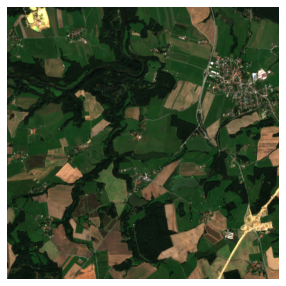

In [9]:
img_f = fnames[7]
img = PILImage.create(img_f)
img.show(figsize=(5,5))

In [10]:
# Napoveda:
#     https://github.com/hiromis/notes/blob/master/Lesson3.md
#     https://docs.python.org/3/library/pathlib.html?highlight=stem#pathlib.PurePath.stem
#     https://forums.fast.ai/t/question-on-get-y-fn/48638

# get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
get_y_fn = lambda x: path_lbl/f'{x.stem}.tif'

<AxesSubplot:>

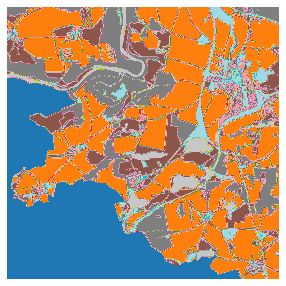

In [11]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,tensor(mask)

(array([549]),
 tensor([[10, 10, 10,  ..., 10, 10, 10],
         [10, 10, 10,  ..., 10, 10, 10],
         [10, 10, 10,  ..., 10, 10, 10],
         ...,
         [ 0,  0,  0,  ...,  2,  2,  2],
         [ 0,  0,  0,  ...,  2,  2,  2],
         [ 0,  0,  0,  ...,  2,  2,  2]], dtype=torch.uint8))

In [13]:
np.unique(tensor(mask))

array([ 0,  2,  5,  7, 10, 11, 13, 14], dtype=uint8)

In [14]:
!cat codes.txt

ocean
ocean
orná_půda
chmelnice
vinice
zahrada
ovocný_sad
trvalý_travní_porost
trvalý_travní_porost
barren
lesní_pozemek
vodní_plocha
nuclear_plant
zastavěná_plocha_a_nádvoří
ostatní_plocha


In [15]:
codes = np.loadtxt('codes.txt', dtype=str); codes

array(['ocean', 'ocean', 'orná_půda', 'chmelnice', 'vinice', 'zahrada',
       'ovocný_sad', 'trvalý_travní_porost', 'trvalý_travní_porost',
       'barren', 'lesní_pozemek', 'vodní_plocha', 'nuclear_plant',
       'zastavěná_plocha_a_nádvoří', 'ostatní_plocha'], dtype='<U26')

In [16]:
len(codes)

15

## Datasets

In [17]:
size = src_size//2
bs=3

In [18]:
valid_fnames = (path/'valid.txt').readlines()
# valid_fnames

In [19]:
# export
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).readlines()
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [20]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=lambda o: path_lbl/f'{o.stem}.tif',
                   batch_tfms=[*aug_transforms(size=(549,549)), Normalize.from_stats(*imagenet_stats)])

In [21]:
dls = camvid.dataloaders(path/"sentinel_tiles", bs=bs, path=path)

<AxesSubplot:>

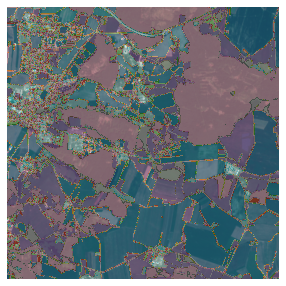

In [22]:
show_at(dls.train_ds, 14)

In [23]:
b = dls.train.one_batch()

In [24]:
b = dls.train.decode(b)

In [25]:
b[0].shape, b[1].shape

(torch.Size([3, 3, 549, 549]), torch.Size([3, 549, 549]))

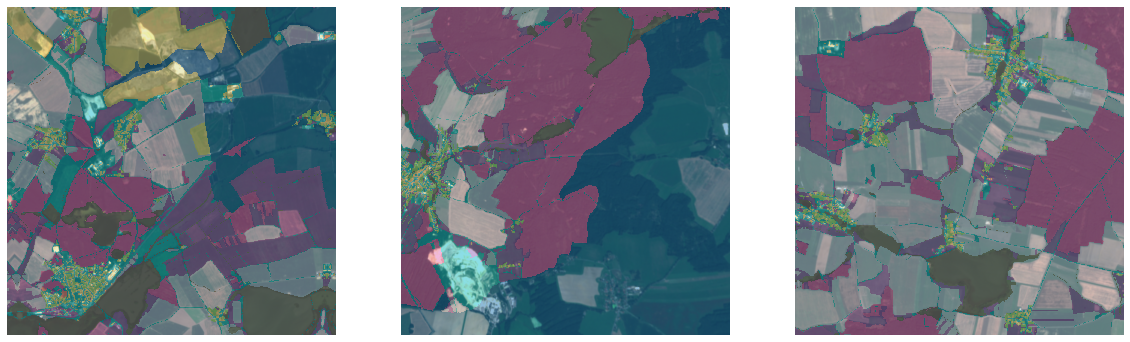

In [26]:
dls.show_batch(max_n=4, figsize=(20,14))

## Model

In [27]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['ocean']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [28]:
metrics=acc_camvid
# metrics=accuracy

In [29]:
wd=1e-2

In [30]:
dls.vocab = codes

In [31]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [32]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

TODO:
    - vysekat nezmapovana mista
    - vyresit chybu: 
        + share memory: https://stackoverflow.com/questions/41037808/how-to-resize-a-shared-memory-in-python
    - omezit pocet obrazku na 5ks

/opt/conda/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=6.30957365501672e-05)

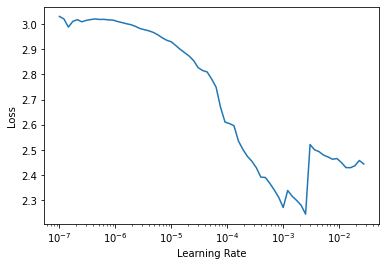

In [34]:
learn.lr_find()

In [35]:
lr=3e-3

In [36]:
learn.fit_one_cycle(4, slice(lr), pct_start=0.9, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.805674,None,None,00:13
1,1.601093,None,None,00:13
2,1.544695,None,None,00:13
3,1.420143,None,None,00:13


In [37]:
learn.save('stage-1')

Path('/workspace/fastcore/models/stage-1.pth')

In [38]:
learn.load('stage-1')

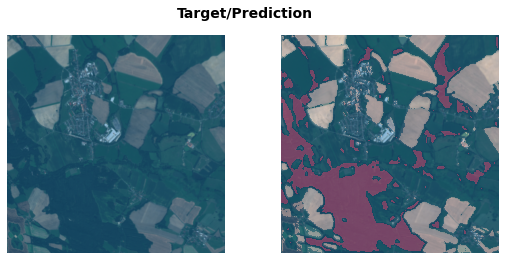

In [39]:
learn.show_results(ds_idx=0, max_n=1, shuffle=False,figsize=(9,4))

In [ ]:
learn.get_preds(ds_idx=0, with_decoded=True)

In [40]:
594/2



198.0